<a href="https://colab.research.google.com/github/AliAlBadra/KerasTFImageClassificationCNN/blob/main/CellSeg_UNet_W_Resizing_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install 'h5py==2.10.0' --force-reinstall

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 

In [1]:
#For live loss function updates
#!pip install livelossplot

In [2]:
%matplotlib inline

In [3]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [4]:
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [6]:
from zipfile import ZipFile
file_name = "/content/images.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
#print(os.listdir("membrane/train"))

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 512 #Resize images (height  = X, width = Y)
SIZE_Y = 512

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/images/train_images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/images/train_masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)


In [6]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)


In [7]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

In [8]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
#from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training (callbacks=[PlotLossesKeras()],)
model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=2000,
   verbose=1,
   validation_data=(x_val, y_val),
)

#accuracy = model.evaluate(x_val, y_val)


Train on 5 samples, validate on 2 samples
Epoch 1/2000
5/5 [==============================] - 25s 5s/step - loss: 5.7152 - iou_score: 0.8251 - val_loss: -16.8576 - val_iou_score: 1.9840
Epoch 2/2000
5/5 [==============================] - 1s 242ms/step - loss: -3.7628 - iou_score: 1.0419 - val_loss: -18.5954 - val_iou_score: 2.0691
Epoch 3/2000
5/5 [==============================] - 1s 244ms/step - loss: -18.3833 - iou_score: 1.4915 - val_loss: -14.5118 - val_iou_score: 1.8041
Epoch 4/2000
5/5 [==============================] - 1s 243ms/step - loss: -26.2755 - iou_score: 1.8253 - val_loss: -13.8039 - val_iou_score: 1.7565
Epoch 5/2000
5/5 [==============================] - 1s 243ms/step - loss: -39.4344 - iou_score: 2.5101 - val_loss: -26.9278 - val_iou_score: 2.8665
Epoch 6/2000
5/5 [==============================] - 1s 243ms/step - loss: -49.4795 - iou_score: 3.4086 - val_loss: -41.2526 - val_iou_score: 4.2707
Epoch 7/2000
5/5 [==============================] - 1s 243ms/step - loss: -

KeyboardInterrupt: ignored

In [10]:
model.save('/content/membrane3000.h5')

In [11]:
from tensorflow import keras
model = keras.models.load_model('/content/membrane3000.h5', compile=False)

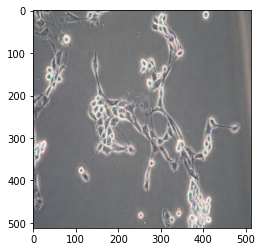

In [12]:

#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/images/test_images/exp8.tif', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)





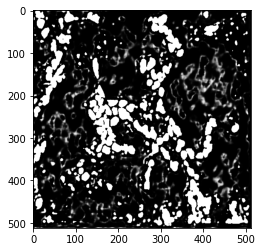

In [13]:
#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
#plt.imsave('images/test_images/segmented.jpg', prediction_image, cmap='gray')
